---
Project Name : Identify Pneumonia with Computer Vision  
Author : Fazrin Muhammad 

---

# **1. Introduction**  

**Background**  
Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

**Objective**  
The aim of this project is to identify pneumonia based on chest X-Ray images. By using computer vision concepts with artificial neural network model.

**Dataset Information**  
This Dataset source from kaggle.com *"Chest X-ray Images"* uploaded by Tolga. This dataset contains 5,856 validated Chest X-Ray images. For access to the dataset source, you can click [here!](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images).

**Deployment**  
For my deployment application of identify pneumia, you can click [here!](https://huggingface.co/spaces/fazrinmuh/GC7).


# **2. Import Libraries**

In [1]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

**Explanation**  
Import libraries for analyze has sucsessfully.

# **3. Data Loading**

In [6]:
# Connecting Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Explanation**  
Connecting goolge colab with my google drive to open the dataset.

In [7]:
# Define dataset
main_path = '/content/drive/MyDrive/chest_xray'

**Explanation**  
main_path is variable for my dataset

In [8]:
# Define train & test
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

**Explanation**  
Create variable for train data and test data.

# **4. EDA**

In [9]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - NORMAL : 1349
Total Data - PNEUMONIA : 3883

Test Path
Total Data - PNEUMONIA : 390
Total Data - NORMAL : 234



**Explanation**  
We have 2 data folder for train and test. From train data we have 1.349 normal images and 3.883 pneumonia images. Then, from test data we have 234 normal and pneumonia 390.

Train Path


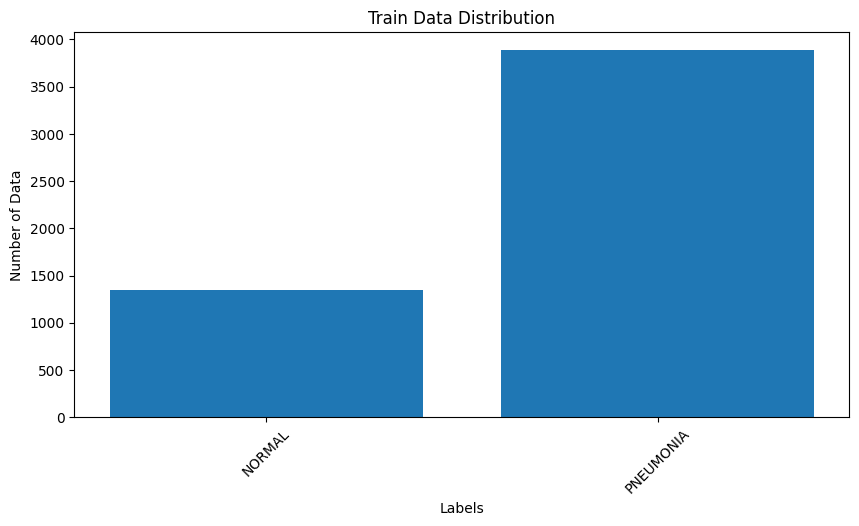

Test Path


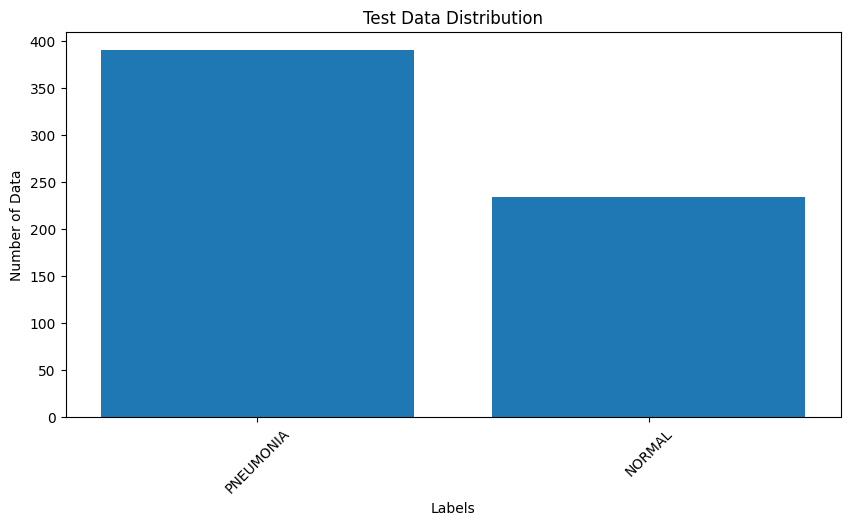

In [10]:
def plot_data_distribution(path, title):
    labels = os.listdir(path)
    num_data = [len(os.listdir(os.path.join(path, label))) for label in labels]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, num_data)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of Data')
    plt.xticks(rotation=45)
    plt.show()

print('Train Path')
plot_data_distribution(train_path, 'Train Data Distribution')

print('Test Path')
plot_data_distribution(test_path, 'Test Data Distribution')

**Explanation**  
The barplot for train and test data about data images total for normal and pneumonia.

In [11]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  NORMAL


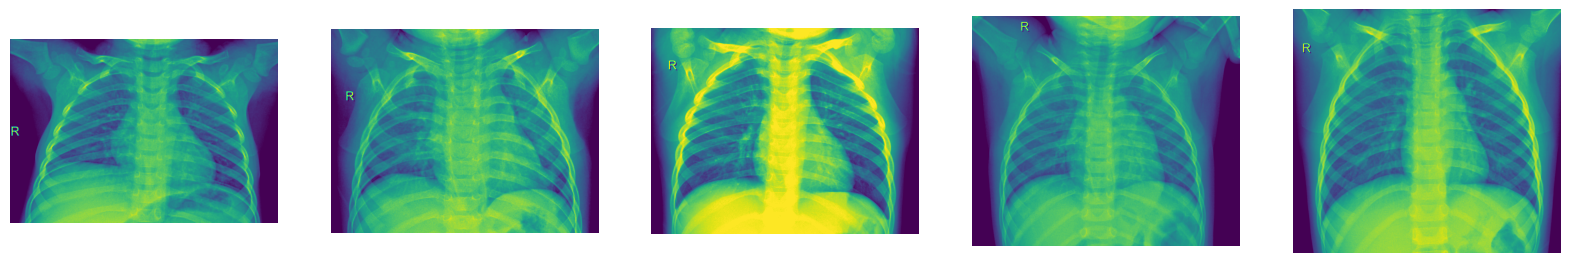

Class :  PNEUMONIA


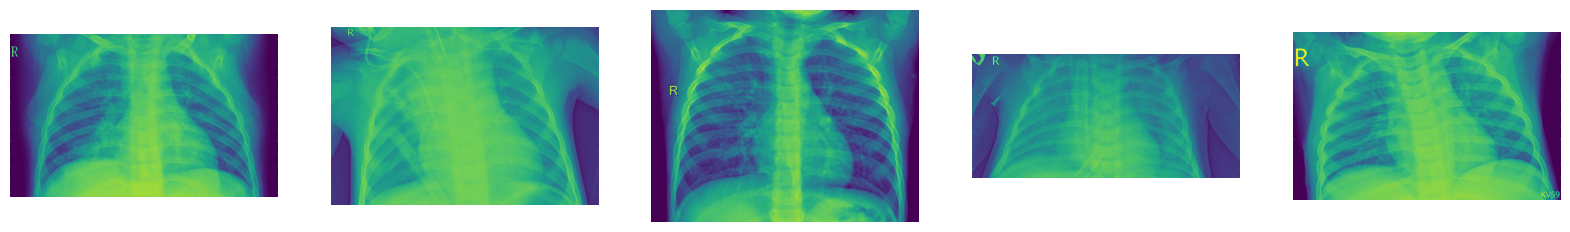

In [12]:
# Visualization of train_path

plot_images(train_path)

**Explanation**  
As you can see above, there are x-rays image of normal and pneumonia from train data.

Class :  PNEUMONIA


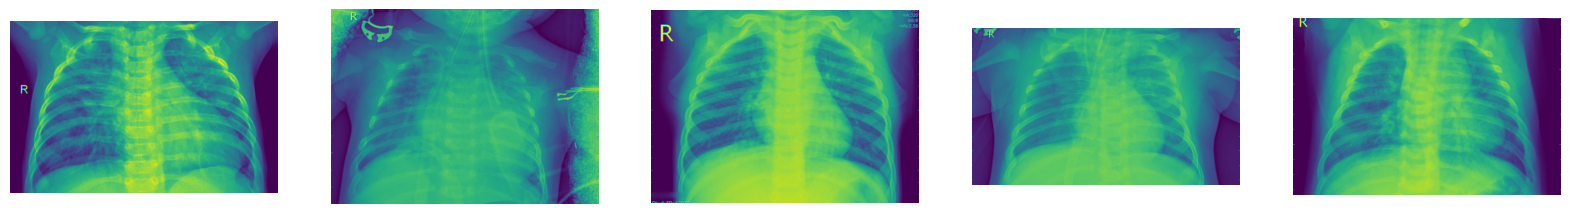

Class :  NORMAL


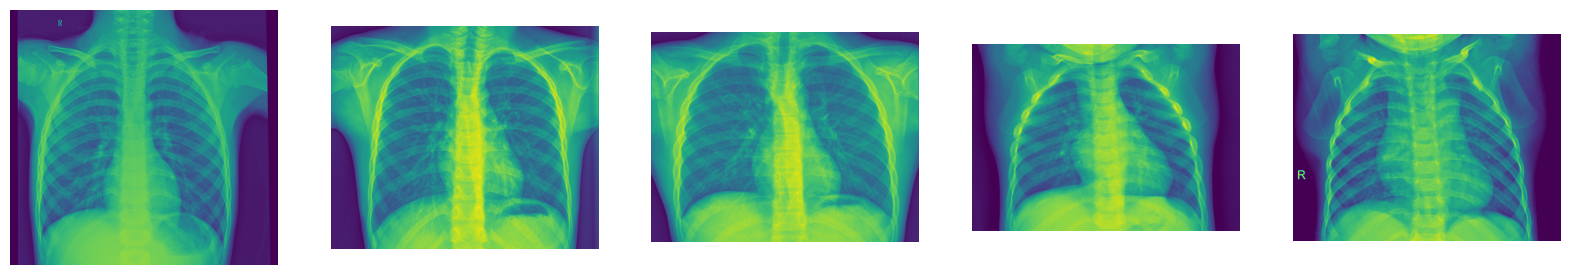

In [13]:
# Visualization of `test_path`

plot_images(test_path)

**Explanation**  
As you can see above, there are x-rays image of normal and pneumonia from test data.

# **5. Model With Data Augmentation**

## 5.1 Preprocessing

In [14]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

**Explanation**  
Hyperparameters with img_height and img_width determine the input of image dimensions, while batch_size determines the number of data samples processed in one training iteration.

In [15]:
# Create data generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                  rescale=1./255,
                                                                  rotation_range=20,
                                                                  zoom_range=0.05,
                                                                  width_shift_range=0.05,
                                                                  height_shift_range=0.05,
                                                                  shear_range=0.05,
                                                                  horizontal_flip=True,
                                                                  validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
                                                    train_path,
                                                    target_size=(img_height, img_width),
                                                    class_mode='binary',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

validation_generator = train_datagen.flow_from_directory(
                                                          train_path,
                                                          target_size=(img_height, img_width),
                                                          class_mode='binary',
                                                          subset='validation',
                                                          batch_size=batch_size,
                                                          shuffle=True,
                                                          seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(
                                                  test_path,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  seed=2)

Found 3140 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Explanation**  
ImageDataGenerator from TensorFlow/Keras to prepare image data for training and testing the model. It involves data augmentation like rotation, zoom, and shifting, as well as rescaling pixel values and creating generators for training, validation, and testing.

## 5.2 Model Definition

In [16]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(20)
tf.random.set_seed(20)

**Explanation**  
The code above is a common pre-training step to clear the previous Keras session and set seeds for NumPy and TensorFlow random number generators.

In [17]:
# Create Sequential model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 128)       0

**Explanation**  
The code above is the creation and compilation of a Sequential model using Keras. The model consists of convolutional layers, dimension reduction, dropout for preventing overfitting, and fully connected layers. It's compiled with binary crossentropy loss, Adam optimizer, and accuracy metric. model.summary() prints a summary of the model architecture.

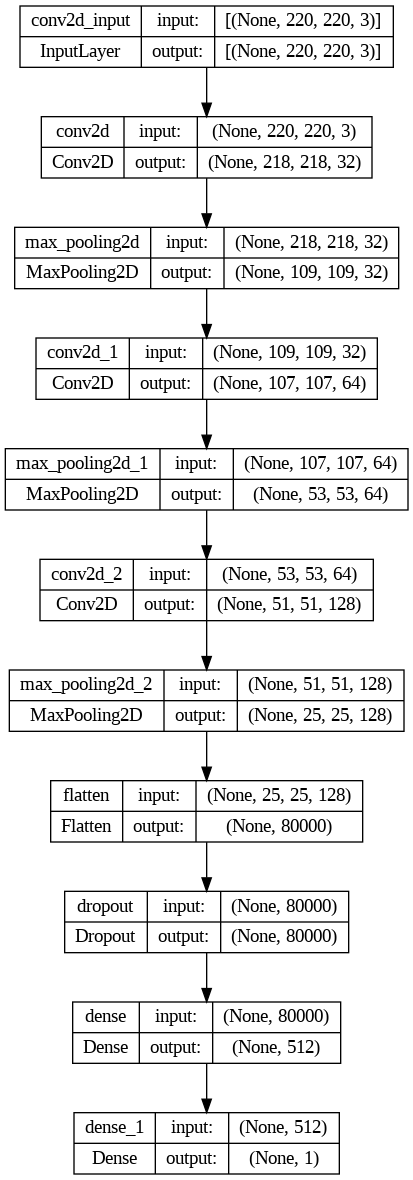

In [18]:
# Plot layers
tf.keras.utils.plot_model(model, show_shapes=True)

**Explanation**  
This utilizes plot_model from TensorFlow/Keras to create a visualization of the model architecture. With `show_shapes=True`, the plot will display the output dimensions of each layer. This aids in understanding the model's structure and data flow visually.

## 5.3 Model Training

In [19]:
# Train the model

%%time
history = model.fit(train_generator, epochs=21, validation_data=validation_generator, batch_size=batch_size)

Epoch 1/21
50/50 [==============================] - 479s 9s/step - loss: 1.0205 - accuracy: 0.6898 - val_loss: 0.5728 - val_accuracy: 0.7424
Epoch 2/21
50/50 [==============================] - 124s 2s/step - loss: 0.5484 - accuracy: 0.7484 - val_loss: 0.4745 - val_accuracy: 0.7424
Epoch 3/21
50/50 [==============================] - 122s 2s/step - loss: 0.4296 - accuracy: 0.7911 - val_loss: 0.3402 - val_accuracy: 0.8528
Epoch 4/21
50/50 [==============================] - 124s 3s/step - loss: 0.2953 - accuracy: 0.8761 - val_loss: 0.2465 - val_accuracy: 0.9120
Epoch 5/21
50/50 [==============================] - 121s 2s/step - loss: 0.2497 - accuracy: 0.9016 - val_loss: 0.1804 - val_accuracy: 0.9407
Epoch 6/21
50/50 [==============================] - 121s 2s/step - loss: 0.2169 - accuracy: 0.9153 - val_loss: 0.2182 - val_accuracy: 0.9140
Epoch 7/21
50/50 [==============================] - 122s 2s/step - loss: 0.2119 - accuracy: 0.9153 - val_loss: 0.1604 - val_accuracy: 0.9350
Epoch 8/21
50

**Explanation**  
This trains the model using a data generator. Using Keras' fit method, the model is trained with data from train_generator, with 21 epochs. Validation data from validation_generator is used to monitor the model's performance during training.

## 5.4 Model Evaluation

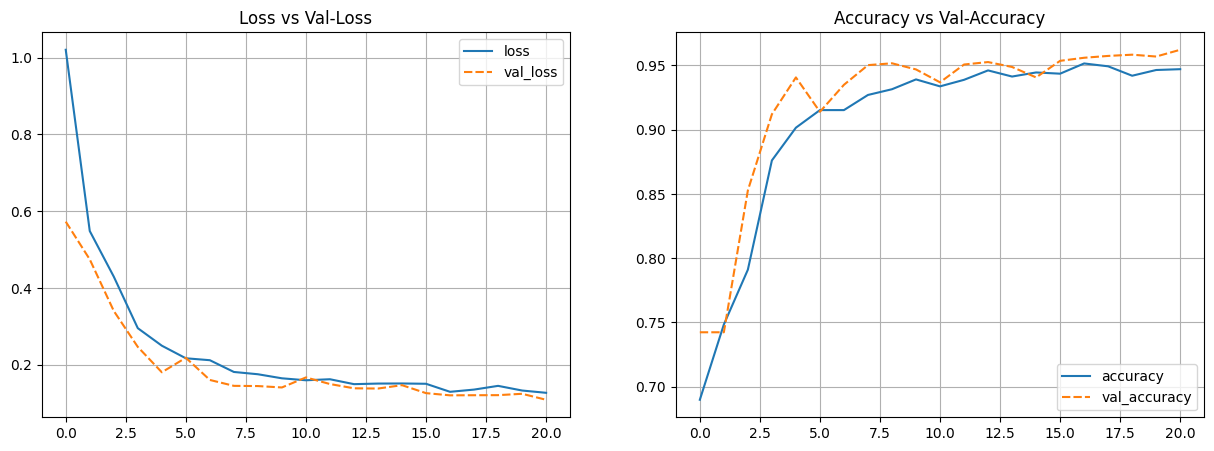

In [20]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

**Explanation**  
The left graph plots the training loss (loss) and validation loss (val_loss) of the model. The x-axis represents the number of epochs, and the y-axis represents the loss value. A decreasing trend in the training loss indicates that the model is learning and improving its ability to make accurate predictions. Training Loss Sharply Decreases, Validation Loss Stagnant or Slightly Increases, this could be a sign of overfitting. The model is focusing too much on memorizing the training data and failing to learn general patterns for other data.

The right graph plots the training accuracy (accuracy) and validation accuracy (val_accuracy) of the model. The x-axis represents the number of epochs, and the y-axis represents the accuracy value. The accuracy metric indicates the proportion of correct predictions made by the model. Training accuracy has an increasing trend this indicates that the model is learning and improving its ability to make accurate predictions. A validation accuracy that is consistently higher than the training accuracy indicates that the model is generalizing well to unseen data.

In [21]:
# Prediksi menggunakan model terbaik
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5)  # Mengubah probabilitas menjadi kelas biner

# Tampilkan laporan klasifikasi
print(classification_report(test_generator.classes, y_pred_binary, target_names=test_generator.class_indices))

10/10 [==============================] - 10s 882ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.61      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



**Explanation**  
Metric Used : Recall

This project aim to predct Diabetes status from individuals, where 0 is normal and 1 is pneumonia. I have chosen to use Recall for metric of evaluation. By using Recall, I will to make sure the False Negative which is people who were predicted normal but were in fact pneumonia. A recall of 1.0 represents perfect recall, meaning the model correctly identified all actual positives.

Recall for the PNEUMONIA class (0.99): This means that out of all the images that are actually PNEUMONIA, the model successfully identifies 99% of them as PNEUMONIA. In other words, out of all patients who actually have pneumonia, the model correctly identifies almost all of them as PNEUMONIA patients. So, the higher the recall for the PNEUMONIA class, the fewer patients with pneumonia are incorrectly identified as NORMAL patients by the model.

# **6. Model Improvement**

## 6.1 Preprocessing

In [40]:
# Define hyperparameters

img_height_tl= 224
img_width_tl= 224
batch_size_tl= 64

**Explanation**  
Hyperparameters with img_height and img_width determine the input of image dimensions, while batch_size determines the number of data samples processed in one training iteration. I used `img_height_tl` and `img_width_tl` 224 because it's requirements for `VGG16` kind of transfer learning model.

In [41]:
# Download pretrained model
from keras.applications.vgg16 import VGG16, preprocess_input

pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height_tl, img_width_tl, 3))
pretrained_model.trainable = False

**Explanation**  
For VGG16, call keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [42]:
# Create batch generator for train-set, val-set, and test-set
train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                                   zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   validation_split=0.4,
                                                                   preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                    target_size=(img_height_tl, img_width_tl),
                                                    class_mode='binary',
                                                    subset='training',
                                                    batch_size=batch_size_tl,
                                                    shuffle=True,
                                                    seed=2)

val_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                  target_size=(img_height_tl, img_width_tl),
                                                  class_mode='binary',
                                                  subset='validation',
                                                  batch_size=batch_size_tl,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_path,
                                                  target_size=(img_height_tl, img_width_tl),
                                                  class_mode='binary',
                                                  batch_size=batch_size_tl,
                                                  shuffle=False,
                                                  seed=2)

Found 3140 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Explanation**  

The code above is creates batch generators for the training, validation, and test datasets using TensorFlow/Keras. The training generator includes data augmentation like rotation, zoom, shifting, and horizontal flipping, along with preprocessing suitable for the VGG16 model. The validation generator uses a subset of the training data, while the test generator does not include augmentation. All generators use target dimensions consistent with the VGG16 model.

## 6.2 Model Definition

In [43]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [44]:
# Create Sequential API model
model_tl = Sequential()
model_tl.add(pretrained_model)
model_tl.add(Flatten())
model_tl.add(Dense(512, activation='relu'))
model_tl.add(Dense(1, activation='sigmoid'))  # Menggunakan satu unit untuk klasifikasi biner dan aktivasi sigmoid

# Compile
model_tl.compile(loss='binary_crossentropy',  # Menggunakan binary_crossentropy sebagai fungsi kerugian
                  optimizer='adam',
                  metrics=['accuracy'])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 12846081 (49.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


**Explanation**  
The code above is utilizes Keras' Sequential API to create a model with layers pretrained from VGG16. The model is then compiled with binary crossentropy as the loss function, Adam optimizer, and accuracy metric.

In [45]:
model_tl.build((None, img_height_tl, img_width_tl, 3))

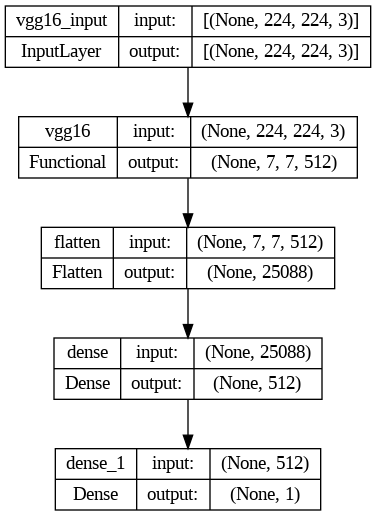

In [46]:
# Plot layers
tf.keras.utils.plot_model(model_tl, show_shapes=True)

**Explanation**  
The code above is a visual plot of the model architecture. With show_shapes=True, the plot displays the output shapes of each layer in the model. This aids in understanding the structure and data flow within the model visually.

## 6.3 Model Training

In [47]:
# Train the model

%%time
history_tl = model_tl.fit(train_set_tl, epochs=21, validation_data=val_set_tl, batch_size=batch_size_tl)

Epoch 1/21
50/50 [==============================] - 132s 3s/step - loss: 7.4706 - accuracy: 0.8764 - val_loss: 0.2372 - val_accuracy: 0.9508
Epoch 2/21
50/50 [==============================] - 128s 3s/step - loss: 0.1404 - accuracy: 0.9631 - val_loss: 0.0672 - val_accuracy: 0.9732
Epoch 3/21
50/50 [==============================] - 127s 3s/step - loss: 0.0780 - accuracy: 0.9688 - val_loss: 0.0937 - val_accuracy: 0.9670
Epoch 4/21
50/50 [==============================] - 158s 3s/step - loss: 0.0624 - accuracy: 0.9768 - val_loss: 0.0559 - val_accuracy: 0.9785
Epoch 5/21
50/50 [==============================] - 127s 3s/step - loss: 0.0489 - accuracy: 0.9799 - val_loss: 0.0756 - val_accuracy: 0.9756
Epoch 6/21
50/50 [==============================] - 127s 3s/step - loss: 0.0575 - accuracy: 0.9771 - val_loss: 0.0589 - val_accuracy: 0.9785
Epoch 7/21
50/50 [==============================] - 128s 3s/step - loss: 0.0418 - accuracy: 0.9841 - val_loss: 0.0739 - val_accuracy: 0.9732
Epoch 8/21
50

**Explanation**  
This trains the model using batch generators for the training and validation datasets. It runs for 21 epochs, and the training time is measured.

## 6.4 Model Evaluation

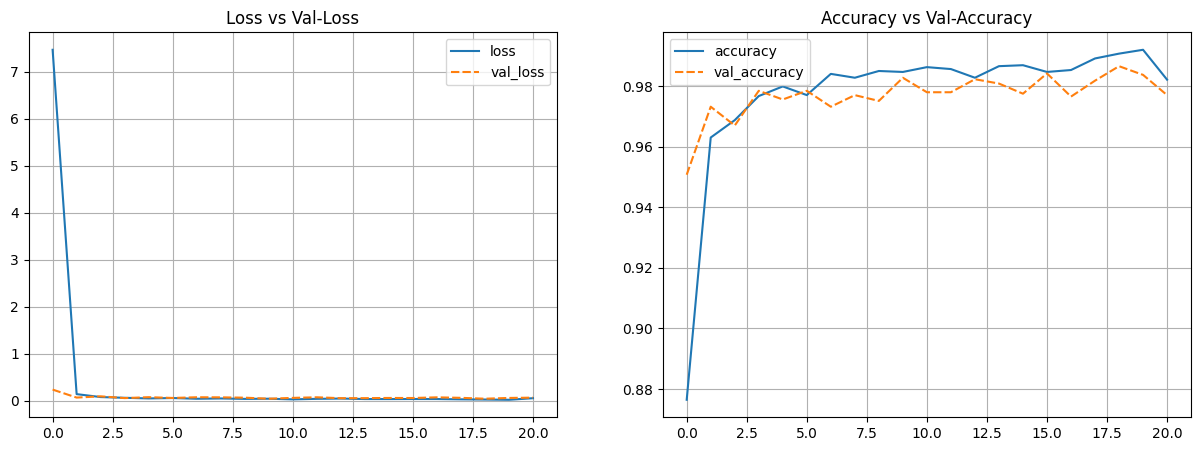

In [48]:
# Plot training results

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

**Explanation**  
The left graph plots the training loss (loss) and validation loss (val_loss) of the model. The x-axis represents the number of epochs, and the y-axis represents the loss value. A decreasing trend in the training loss indicates that the model is learning and improving its ability to make accurate predictions. A stagnan trend in the validation loss indicates that the model is almost perfect to make accurate predictions and generalizing well to unseen data.


The right graph plots the training accuracy (accuracy) and validation accuracy (val_accuracy) of the model. The x-axis represents the number of epochs, and the y-axis represents the accuracy value. An increasing trend in the training accuracy indicates that the model is learning and improving its ability to make accurate predictions. A validation accuracy that is consistently lower than the training accuracy suggests that the model is overfitting to the training data.

In [49]:
# Get the probability
y_pred_prob_tl = model_tl.predict(test_set_tl)

# Get class with maximum probability
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype('int32')

# Get class label based on generator data
y_true_tl = test_set_tl.classes

# Get name classes
class_labels_tl = list(test_set_tl.class_indices.keys())

# Display Classification Report
print(classification_report(y_true_tl, y_pred_class_tl, target_names=class_labels_tl))


10/10 [==============================] - 10s 931ms/step
              precision    recall  f1-score   support

      NORMAL       0.99      0.78      0.88       234
   PNEUMONIA       0.88      1.00      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.89      0.91       624
weighted avg       0.93      0.92      0.91       624



**Explanation**  
Recall is the percentage of all positive cases correctly identified by the model out of all actual positive cases. In this context, the recall for nomral is 0.78, which means that out of all images of patients who are actually normal, the model successfully identifies 78% of them as normal. Meanwhile, for pneumonia, the recall is 1.00, indicating that the model successfully identifies all actual pneumonia cases as pneumonia.

# **7. Model Saving**

In [61]:
# Save Model
model_tl.save('model_tl.h5')

**Explanation**  
I choose model from transfer learning to be my best model for this project. Because the model has increasing result of recall both of pneumonia and normal. Then, the model also has more efficien than base model.

# **8. Model Inference**

**Explanation**  
I create the model inference on another notebook. The notebook name is P2G7_fazrinmuh_inf.

# **9. Conclusion**

**EDA**  
- In this project I have total 5.856 images data of X-rays such as 1.583 normal x-rays and 4.273 pneumia x-rays.
- Train data such as 1.349 normal and 3.883 pneumonia of x-ray images.
- Test data such as 234 normal and 390 pneumonia of x-ray images.

**Metric Evaluation**  
Metric Used : Recall
This project aim to predct Diabetes status from individuals, where 0 is normal and 1 is pneumonia. I have chosen to use Recall for metric of evaluation. By using Recall, I will to make sure the False Negative which is people who were predicted normal but were in fact pneumonia. A recall of 1.0 represents perfect recall, meaning the model correctly identified all actual positives.

**Model Analysis**  
Base Model:
- I used model with augmentation as base model. Data augmentation like rotation, zoom, and shifting, as well as rescaling pixel values and creating generators for training, validation, and testing.
- The base model using sequential API consists of convolutional layers, dimension reduction, dropout for preventing overfitting, and fully connected layers. It's compiled with binary crossentropy loss, Adam optimizer, and accuracy metric.
- Fit model using 21 epochs to find the best model.
- Evaluation of base model.  A decreasing trend in the training loss indicates that the model is learning and improving its ability to make accurate predictions. Training Loss Sharply Decreases, Validation Loss Stagnant or Slightly Increases, this could be a sign of overfitting. The model is focusing too much on memorizing the training data and failing to learn general patterns for other data. Then, Training accuracy has an increasing trend this indicates that the model is learning and improving its ability to make accurate predictions. A validation accuracy that is consistently higher than the training accuracy indicates that the model is generalizing well to unseen data.
- Recall for the PNEUMONIA class (0.99): This means that out of all the images that are actually PNEUMONIA, the model successfully identifies 99% of them as PNEUMONIA. In other words, out of all patients who actually have pneumonia, the model correctly identifies almost all of them as PNEUMONIA patients. So, the higher the recall for the PNEUMONIA class, the fewer patients with pneumonia are incorrectly identified as NORMAL patients by the model.

Improvement Model:  
- For the improvement model I used a transfer learning. Transfer learning is a technique where a model trained on one task or dataset is adapted and fine-tuned for a different but related task or dataset. It leverages knowledge gained from the source task to improve performance on the target task.
- I choose VGG16 as model of transfer learning, that call keras.applications.vgg16.preprocess_input. Then, on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
- Same as base model, I used sequential API to create a model with layers pretrained from VGG16. then compiled with binary crossentropy as the loss function, Adam optimizer, and accuracy metric.
- I also using 21 epochs to find the best model.
- Evaluation improvement model. A decreasing trend in the training loss indicates that the model is learning and improving its ability to make accurate predictions. A stagnan trend in the validation loss indicates that the model is almost perfect to make accurate predictions and generalizing well to unseen data. An increasing trend in the training accuracy indicates that the model is learning and improving its ability to make accurate predictions. A validation accuracy that is consistently lower than the training accuracy suggests that the model is overfitting to the training data.
- Recall is the percentage of all positive cases correctly identified by the model out of all actual positive cases. In this context, the recall for nomral is 0.78, which means that out of all images of patients who are actually normal, the model successfully identifies 78% of them as normal. Meanwhile, for pneumonia, the recall is 1.00, indicating that the model successfully identifies all actual pneumonia cases as pneumonia.

I used Improvement model for my best model. Because the model has increasing result of recall both of pneumonia and normal. Then, the model also has more efficien than base model.


**Overall Analysis**  
In this project, I analyzed a dataset comprising 5,856 X-ray images, including 1,583 normal and 4,273 pneumonia cases, split into training and testing sets. Our focus was on predicting pneumonia status using Recall as the main evaluation metric. Initially, we employed data augmentation and built a base model, observing trends in training and validation metrics to identify potential overfitting. Subsequently, we explored transfer learning with VGG16, leading to improved recall rates for both normal and pneumonia cases. The transfer learning approach proved effective, offering enhanced performance and efficiency in predicting pneumonia status from X-ray images.